# Model Training using KNN Imputation
---
In this file, I will train the model using KNN imputation to handle missing values

Connecting to database...
Connection successful!
Loaded 261173 players
Total dataset: 261,173 samples
Training set: 208,938 samples
Test set: 52,235 samples

Training class distribution:
  Banned: 35,298 (16.89%)
  Non-banned: 173,640 (83.11%)

Test class distribution:
  Banned: 8,824 (16.89%)
  Non-banned: 43,411 (83.11%)
Original training set shape: (208938, 31)
Resampled training set shape: (319783, 31)

Original distribution:
  Banned: 35,298 (16.89%)
  Non-banned: 173,640 (83.11%)

Resampled distribution:
  Banned: 168,459 (52.68%)
  Non-banned: 151,324 (47.32%)


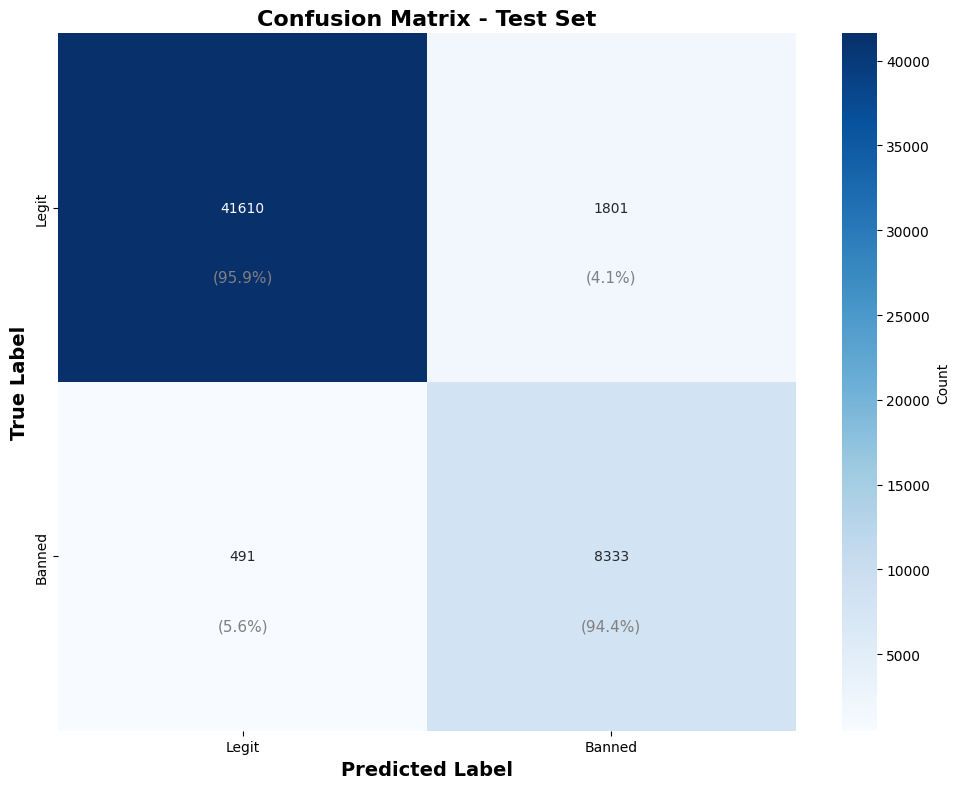

Metrics:
  ROC-AUC Score:           0.9866
  Precision (Banned):      0.8223
  Recall (Banned):         0.9444
  F1-Score (Banned):       0.8791
  False Positive Rate:     0.0415 (1,801 legit players incorrectly flagged)
  False Negative Rate:     0.0556 (491 cheaters missed)
  True Positives:          8,333 cheaters correctly identified
  True Negatives:          41,610 legit players correctly identified


In [1]:
from Utils import setup_database_connection, true, false, evaluate_model
from Utils import load_all_players
from Utils import COLOUR_BANNED, COLOUR_NON_BANNED, COLOUR_BLUE
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

engine = setup_database_connection()
player_data = load_all_players(engine)
banned_player_data = player_data[player_data['has_ban'] == true]
non_banned_player_data = player_data[player_data['has_ban'] == false]

features_to_exclude = ['he_friends_damage_avg', 'rating_opening', 'rating_ct_leetify', 'rating_t_leetify', 't_opening_aggression_success_rate', 'rating_clutch', 'steam_id', 'created_at', 'updated_at', 'rank_premier', 'rank_faceit_elo', 'total_matches']

numeric_cols = player_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in features_to_exclude]

banned_means = banned_player_data[numeric_cols].mean()
non_banned_means = non_banned_player_data[numeric_cols].mean()

banned_data = banned_player_data.copy()
non_banned_data = non_banned_player_data.copy()

for col in numeric_cols:
    banned_data.loc[banned_data[col] == 0, col] = np.nan
    non_banned_data.loc[non_banned_data[col] == 0, col] = np.nan

knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

banned_imputed_values = knn_imputer.fit_transform(banned_data[numeric_cols])
banned_imputed = banned_data.copy()
banned_imputed[numeric_cols] = banned_imputed_values

non_banned_imputed_values = knn_imputer.fit_transform(non_banned_data[numeric_cols])
non_banned_imputed = non_banned_data.copy()
non_banned_imputed[numeric_cols] = non_banned_imputed_values

imputed_player_data = pd.concat([banned_imputed, non_banned_imputed], ignore_index=True)

columns_to_exclude = ['steam_id', 'created_at', 'name', 'total_matches', 'updated_at', 'has_ban']
X = imputed_player_data.drop(columns=columns_to_exclude)
y = imputed_player_data['has_ban'].map({true: 1, false: 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,
    stratify=y
)

print(f"Total dataset: {X.shape[0]:,} samples")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(f"  Banned: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"  Non-banned: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"\nTest class distribution:")
print(f"  Banned: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")
print(f"  Non-banned: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")

print(f"\nOriginal distribution:")
print(f"  Banned: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"  Non-banned: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")

print(f"\nResampled distribution:")
print(f"  Banned: {(y_train_resampled == 1).sum():,} ({(y_train_resampled == 1).sum()/len(y_train_resampled)*100:.2f}%)")
print(f"  Non-banned: {(y_train_resampled == 0).sum():,} ({(y_train_resampled == 0).sum()/len(y_train_resampled)*100:.2f}%)")

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_resampled, y_train_resampled)
metrics = evaluate_model(clf, X_test, y_test, show_plot=True)